## **Regression-Based Rating Score Prediction Using Embedding Features (Model Selection)**

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### **Data Preparation**

In [2]:
rating_df = pd.read_csv('ratings.csv')
user_emb = pd.read_csv('User_Embeddings.csv')
item_emb = pd.read_csv('Course_Embeddings.csv')
course_df = pd.read_csv('course_processed.csv')

In [3]:
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [4]:
user_emb.head()

,User_ID,User_Feature_0,User_Feature_1,User_Feature_2,User_Feature_3,User_Feature_4,User_Feature_5,User_Feature_6,User_Feature_7,User_Feature_8,User_Feature_9,User_Feature_10,User_Feature_11,User_Feature_12,User_Feature_13,User_Feature_14,User_Feature_15
0,1889878,-0.016606,-0.016088,-0.003369,-0.035137,0.000975,0.017438,-0.010913,0.007628,0.016686,0.004802,0.005720,-0.011686,-0.005172,0.009153,-0.015774,0.004194
1,1342067,-0.034844,-0.002126,-0.017890,-0.028600,-0.011657,0.004055,0.002278,0.004140,0.009584,0.016630,0.012418,0.020363,-0.016852,-0.037288,0.017049,-0.004547
2,1990814,-0.002432,-0.021900,-0.018091,0.012186,-0.001424,-0.015392,0.008118,-0.016446,-0.001566,0.002180,0.017815,-0.012579,0.007957,-0.013742,0.026470,-0.001333
3,380098,-0.000387,-0.018908,0.000263,0.009960,0.024397,0.003105,-0.005399,0.010141,0.012209,-0.004895,-0.014266,-0.009943,0.010241,0.019553,0.013327,-0.002911
4,779563,0.013837,0.002045,-0.005562,0.003339,-0.019105,-0.000067,0.012716,-0.001674,0.000287,-0.016167,0.024513,-0.000466,-0.000027,-0.012555,0.005529,-0.017677


In [5]:
item_emb.head()

,Course_ID,Course_Feature_0,Course_Feature_1,Course_Feature_2,Course_Feature_3,Course_Feature_4,Course_Feature_5,Course_Feature_6,Course_Feature_7,Course_Feature_8,Course_Feature_9,Course_Feature_10,Course_Feature_11,Course_Feature_12,Course_Feature_13,Course_Feature_14,Course_Feature_15
0,CC0101EN,-0.039493,-0.046961,-0.031280,-0.015159,-0.257076,0.007762,-0.120023,0.118434,0.094517,0.279441,-0.110488,0.054886,-0.029876,-0.071809,-0.010483,0.079570
1,CL0101EN,-0.072549,0.056140,0.294247,-0.090112,-0.081289,0.243462,0.267263,-0.025282,0.033823,0.194806,-0.017052,0.044629,-0.251677,-0.140366,0.158388,0.120748
2,ML0120ENv3,-0.017471,0.044615,-0.099044,-0.011788,0.039947,0.176448,-0.034120,0.071215,-0.063434,-0.107145,-0.065945,-0.045263,0.020473,-0.097950,0.076773,0.057337
3,BD0211EN,0.233830,-0.080934,-0.058808,-0.084407,0.118824,-0.182455,0.193202,-0.043035,0.250306,-0.011129,0.025923,-0.289598,0.107959,0.287435,0.065177,-0.055921
4,DS0101EN,0.221674,-0.012474,0.278967,0.040157,0.084193,-0.012153,0.123990,0.173688,0.142995,-0.113967,0.079826,0.059155,-0.090087,0.125606,-0.014606,-0.088862


In [6]:
train_list = []
test_list = []

for user_id, user_data in rating_df.groupby('user'):
    if len(user_data) == 1:
        train_list.append(user_data)
    else:
        test_sample = user_data.sample(frac=0.2, random_state=42)
        train_sample = user_data.drop(test_sample.index)
        train_list.append(train_sample)
        test_list.append(test_sample)

train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

In [7]:
# Merge user embedding features (training df)
user_emb_train_merged = pd.merge(train_df, user_emb, how='left', left_on='user', right_on='User_ID').fillna(0)
# Merge course embedding features (training df)
merged_train_df = pd.merge(user_emb_train_merged, item_emb, how='left', left_on='item', right_on='Course_ID').fillna(0)

# Merge user embedding features (testing df)
user_emb_test_merged = pd.merge(test_df, user_emb, how='left', left_on='user', right_on='User_ID').fillna(0)
# Merge course embedding features (testing df)
merged_test_df = pd.merge(user_emb_test_merged, item_emb, how='left', left_on='item', right_on='Course_ID').fillna(0)

In [8]:
u_feautres = [f"User_Feature_{i}" for i in range(user_emb.shape[1] - 1)]
c_features = [f"Course_Feature_{i}" for i in range(item_emb.shape[1] - 1)]

user_train_embeddings = merged_train_df[u_feautres]
course_train_embeddings = merged_train_df[c_features]
ratings_train = merged_train_df['rating']

user_test_embeddings = merged_test_df[u_feautres]
course_test_embeddings = merged_test_df[c_features]
ratings_test = merged_test_df['rating']

x_train = user_train_embeddings + course_train_embeddings.values
x_train.columns = [f"Feature_{i}" for i in range(item_emb.shape[1] - 1)]
y_train = ratings_train

x_test = user_test_embeddings + course_test_embeddings.values
x_test.columns = [f"Feature_{i}" for i in range(item_emb.shape[1] - 1)]
y_test = ratings_test

##### **Model Selection**

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

try:
    from xgboost import XGBRegressor
    xgb_installed = True
except ImportError:
    xgb_installed = False

models_and_parameters = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    },
    'Lasso': {
        'model': Lasso(),
        'params': {'alpha': [0.001, 0.01, 0.1, 1, 10]}
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.01, 0.1, 1],
            'l1_ratio': [0.2, 0.5, 0.8]
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 10],
            'weights': ['uniform', 'distance']
        }
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    }
}

if xgb_installed:
    models_and_parameters['XGBRegressor'] = {
        'model': XGBRegressor(objective='reg:squarederror', verbosity=0),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    }

models_requiring_scaling = ['LinearRegression', 'Ridge', 'Lasso', 'SVR', 'KNeighborsRegressor', 'ElasticNet']

results = []

for name, mp in models_and_parameters.items():
    print(f"Running GridSearchCV for {name}...")

    if name in models_requiring_scaling:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', mp['model'])
        ])
    else:
        pipe = Pipeline([
            ('model', mp['model'])  
        ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid={'model__' + k: v for k, v in mp['params'].items()},
        scoring='neg_root_mean_squared_error',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(x_train, y_train)
    y_pred = grid.predict(x_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

result_df = pd.DataFrame(results).sort_values('RMSE')
result_df

Running GridSearchCV for LinearRegression...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Running GridSearchCV for Ridge...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Running GridSearchCV for Lasso...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Running GridSearchCV for ElasticNet...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Running GridSearchCV for KNeighborsRegressor...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Running GridSearchCV for DecisionTreeRegressor...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Running GridSearchCV for RandomForestRegressor...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Running GridSearchCV for GradientBoostingRegressor...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Running GridSearchCV for XGBRegressor...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


,Model,Best Params,MAE,MSE,RMSE,R2
6,RandomForestRegressor,"{'model__max_depth': 20, 'model__min_samples_s...",0.025125,0.008631,0.092906,0.074757
7,GradientBoostingRegressor,"{'model__learning_rate': 0.1, 'model__max_dept...",0.031730,0.009252,0.096186,0.008278
8,XGBRegressor,"{'model__learning_rate': 0.1, 'model__max_dept...",0.031640,0.009329,0.096587,-0.000017
5,DecisionTreeRegressor,"{'model__max_depth': 10, 'model__min_samples_s...",0.029546,0.010984,0.104807,-0.177462
2,Lasso,{'model__alpha': 0.01},0.063895,0.012231,0.110595,-0.311116
3,ElasticNet,"{'model__alpha': 0.01, 'model__l1_ratio': 0.8}",0.064337,0.012486,0.111740,-0.338410
4,KNeighborsRegressor,"{'model__n_neighbors': 5, 'model__weights': 'd...",0.024864,0.014044,0.118507,-0.505411
1,Ridge,{'model__alpha': 100},0.071315,0.014476,0.120316,-0.551741
0,LinearRegression,{},0.071342,0.014482,0.120343,-0.552418


In [10]:
abbreviations = {
    "LinearRegression": "LR",
    "Ridge": "Ridge",
    "Lasso": "Lasso",
    "ElasticNet": "ENet",
    "KNeighborsRegressor": "KNN",
    "DecisionTreeRegressor": "DTR",
    "RandomForestRegressor": "RFR",
    "GradientBoostingRegressor": "GBR",
    "XGBRegressor": "XGB"
}

result_df['Model_Abbr'] = result_df['Model'].map(abbreviations)
result_df


,Model,Best Params,MAE,MSE,RMSE,R2,Model_Abbr
6,RandomForestRegressor,"{'model__max_depth': 20, 'model__min_samples_s...",0.025125,0.008631,0.092906,0.074757,RFR
7,GradientBoostingRegressor,"{'model__learning_rate': 0.1, 'model__max_dept...",0.031730,0.009252,0.096186,0.008278,GBR
8,XGBRegressor,"{'model__learning_rate': 0.1, 'model__max_dept...",0.031640,0.009329,0.096587,-0.000017,XGB
5,DecisionTreeRegressor,"{'model__max_depth': 10, 'model__min_samples_s...",0.029546,0.010984,0.104807,-0.177462,DTR
2,Lasso,{'model__alpha': 0.01},0.063895,0.012231,0.110595,-0.311116,Lasso
3,ElasticNet,"{'model__alpha': 0.01, 'model__l1_ratio': 0.8}",0.064337,0.012486,0.111740,-0.338410,ENet
4,KNeighborsRegressor,"{'model__n_neighbors': 5, 'model__weights': 'd...",0.024864,0.014044,0.118507,-0.505411,KNN
1,Ridge,{'model__alpha': 100},0.071315,0.014476,0.120316,-0.551741,Ridge
0,LinearRegression,{},0.071342,0.014482,0.120343,-0.552418,LR


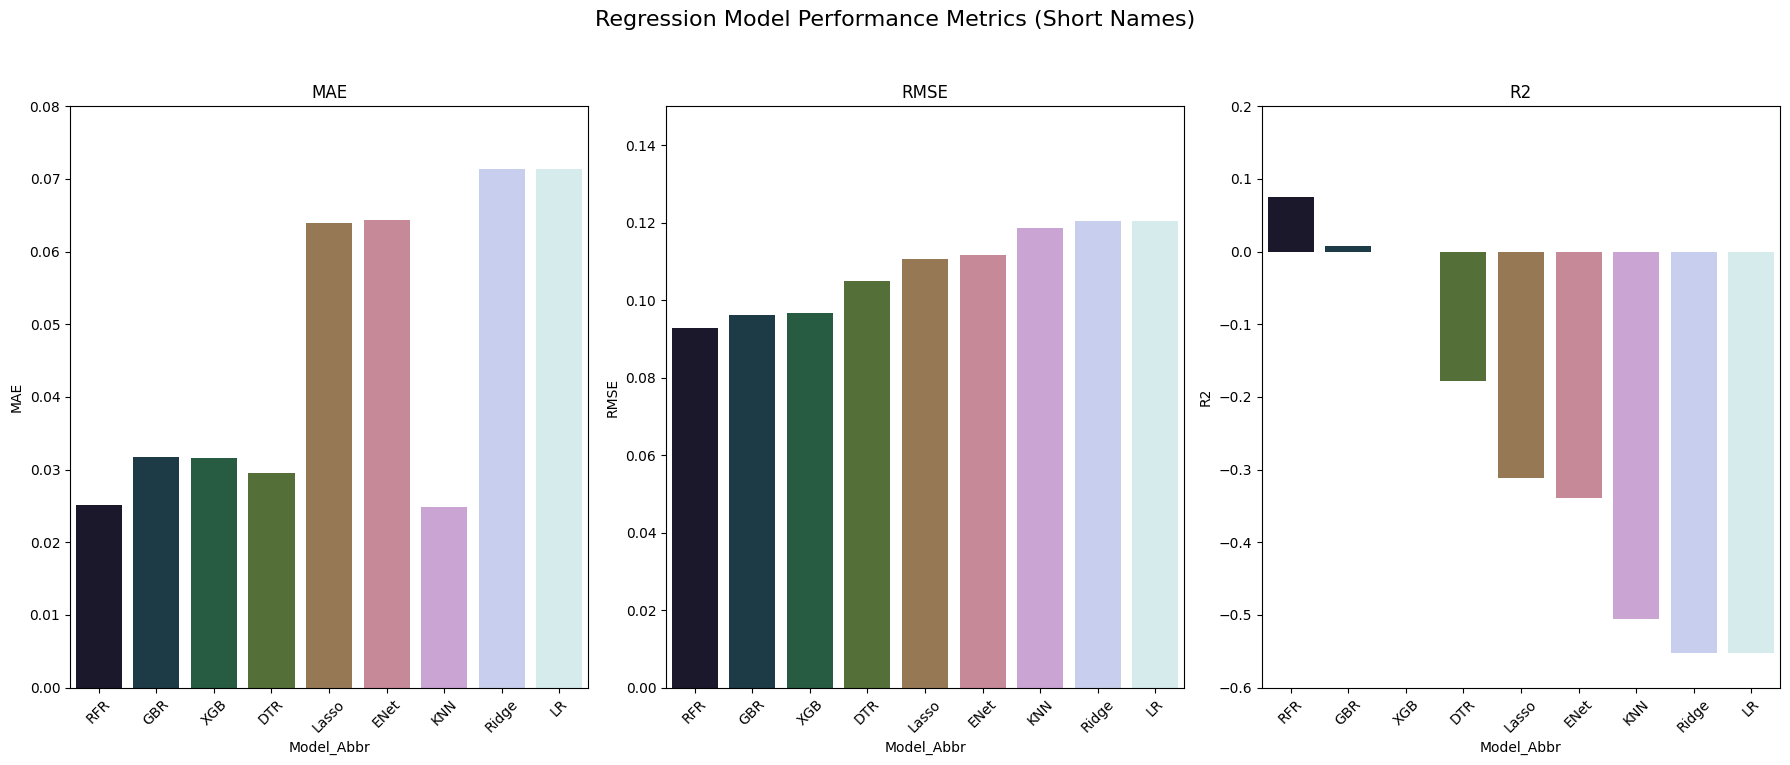

In [ ]:
reg_ylim_ranges = {
    'MAE': (0.0, 0.08),
    'RMSE': (0.0, 0.15),
    'R2': (-0.6, 0.2)
}

reg_metrics = ['MAE', 'RMSE', 'R2']

plt.figure(figsize=(18, 8))

for i, metric in enumerate(reg_metrics, 1):
    plt.subplot(1, 3, i)
    sns.barplot(data=result_df, x='Model_Abbr', y=metric, palette="cubehelix")
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.ylim(reg_ylim_ranges[metric])
    plt.tight_layout()

plt.suptitle("Regression Model Performance Metrics (Short Names)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


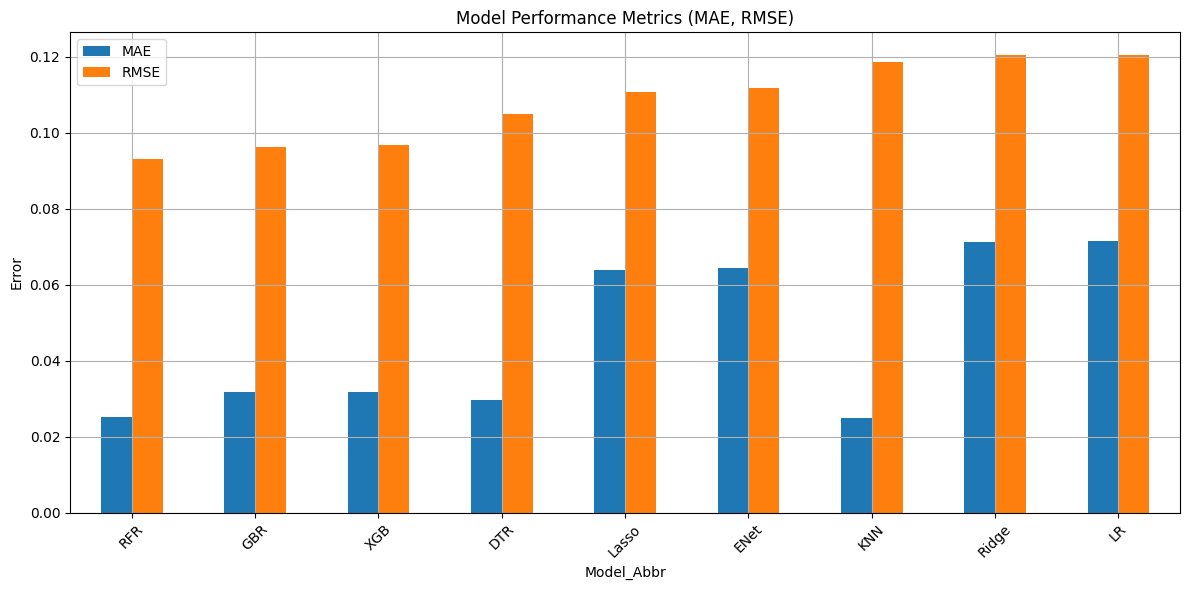

In [15]:
metrics_df = result_df[['Model_Abbr', 'MAE', 'RMSE']].set_index('Model_Abbr')

metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Metrics (MAE, RMSE)')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: xlabel='Model_Abbr', ylabel='Score'>

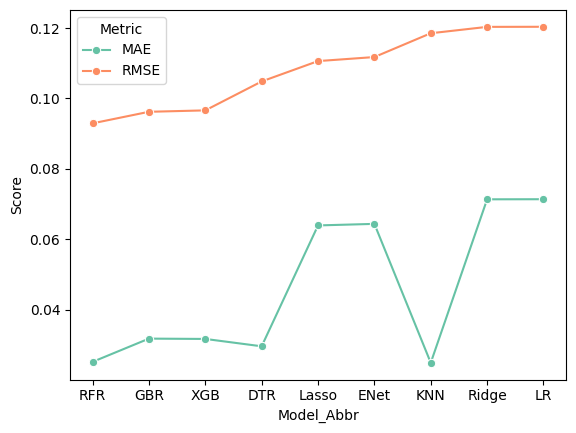

In [14]:
long_df = result_df.melt(id_vars="Model_Abbr", 
                          value_vars=["MAE", "RMSE"], 
                          var_name="Metric", value_name="Score")

sns.lineplot(data=long_df, x="Model_Abbr", y="Score", hue="Metric", marker="o", palette="Set2")

#### **Hyper Parameter Tuning**

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,               
    cv=3,
    verbose=2,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=42
)

random_search.fit(x_train, y_train)

best_rf = random_search.best_estimator_

y_pred = best_rf.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", random_search.best_params_)
print("Test RMSE:", rmse)
print("Test R² Score:", r2)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Test RMSE: 0.091245855806144
Test R² Score: 0.10752375374683754


#### **Training Finally Tuned Regression Model**

In [20]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=20,
    random_state=42
)

rf_model.fit(x_train, y_train)
rf_predictions = rf_model.predict(x_test)

mae = mean_absolute_error(y_test, rf_predictions)
mse = mean_squared_error(y_test, rf_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, rf_predictions)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2_Score:", r2)

MAE: 0.025047821664110848
MSE: 0.008325806201795623
RMSE: 0.091245855806144
R2_Score: 0.10752375374683754


#### **Recommending Courses Based On Regression Model**

In [ ]:
def regression_prediction(model, user_id, user_emb, item_emb):
    
    enrolled_courses = set(rating_df[rating_df['user'] == user_id]['item'].values.tolist())
    all_courses = set(rating_df['item'].values.tolist())

    item_embedding = item_emb[item_emb['Course_ID'].isin(all_courses - enrolled_courses)]
    user_embedding = user_emb[user_emb['User_ID'] == user_id].iloc[:,1:].values

    test_df = pd.DataFrame(item_embedding.iloc[:,1:].values + user_embedding, columns=[f"Feature_{i}" for i in range(user_emb.shape[1]-1)])
    test_df.insert(0, 'Course_ID', item_embedding.iloc[:,0].values)
    prediction_df = pd.DataFrame({'Course_ID' : item_embedding.iloc[:,0].values, 'Score' : (model.predict(test_df.iloc[:,1:])/3)*100})
    prediction_df.sort_values('Score', ascending = False, inplace = True)
    return prediction_df

In [22]:
prediction = regression_prediction(rf_model, 741496, user_emb, item_emb)

In [23]:
pd.merge(prediction, course_df, left_on='Course_ID', right_on='COURSE_ID', how='left')[['Course_ID', 'TITLE', 'Score']].head(10)

,Course_ID,TITLE,Score
0,BD0141EN,accessing hadoop data using hive,99.998572
1,DA0101EN,data analysis with python,99.997152
2,CO0101EN,docker essentials a developer introduction,99.997011
3,CO0201EN,container kubernetes essentials with ibm cloud,99.995742
4,BC0101EN,blockchain essentials,99.993950
5,CO0301EN,getting started with microservices with istio ...,99.989995
6,BD0223EN,exploring spark s graphx,99.989649
7,ML0101ENv3,machine learning with python,99.988270
8,ML0120EN,deep learning with tensorflow,99.986568
9,CO0401EN,beyond the basics istio and ibm cloud kuberne...,99.986190
